# Tutorial 6 - Gastric cancer (Visium + COMET)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Gastric_cancer'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path, 'PCA-NCI-E44', 'adata_PCA-NCI-E44_rna.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path, 'PCA-NCI-E29', 'adata_comet_normalized.h5ad'))

adata1_rna, adata2_adt

(AnnData object with n_obs × n_vars = 825621 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial',
 AnnData object with n_obs × n_vars = 741804 × 19
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_dapi')

In [5]:
adata1_rna.var_names_make_unique()
adata2_adt.var_names_make_unique()

In [6]:
adata1_he = sc.AnnData(X=adata1_rna.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_adt.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata1_rna.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_adt.obsm['spatial'].copy()
adata1_he, adata2_he

(AnnData object with n_obs × n_vars = 825621 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 741804 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [7]:
data_dict = {
        'HE': [adata1_he, adata2_he],
        'RNA': [adata1_rna, None],
        'Protein': [None, adata2_adt],
    }

In [8]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-06-16 14:53:15,484 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-16 14:53:36,619 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-16 14:53:40,104 - harmonypy - INFO - Iteration 1 of 10
2025-06-16 14:56:07,035 - harmonypy - INFO - Iteration 2 of 10
2025-06-16 14:58:55,575 - harmonypy - INFO - Iteration 3 of 10
2025-06-16 15:01:27,537 - harmonypy - INFO - Iteration 4 of 10
2025-06-16 15:03:42,004 - harmonypy - INFO - Iteration 5 of 10
2025-06-16 15:05:13,145 - harmonypy - INFO - Iteration 6 of 10
2025-06-16 15:06:21,324 - harmonypy - INFO - Iteration 7 of 10
2025-06-16 15:07:31,602 - harmonypy - INFO - Iteration 8 of 10
2025-06-16 15:08:52,516 - harmonypy - INFO - Iteration 9 of 10
2025-06-16 15:10:14,100 - harmonypy - INFO - Iteration 10 of 10
2025-06-16 15:11:45,828 - harmonypy - INFO - Stopped before convergence


-------- Processing unique modality RNA for section 1 --------
-------- Processing unique modality Protein for section 2 --------
using arcsinh
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training.

In [11]:
Linkage_indicator = {
        ('s1', 's2'): [('HE', 'HE'),('RNA', 'Protein')]
    }

## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 15 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=1, n_y=2)

-------- Running Sub-graph training mode, n_x is 1, n_y is 2 --------
Splitting section [s1] into 1 x 2 subgraphs
Splitting HE in section s1...
Splitting RNA in section s1...
Splitting section [s2] into 1 x 2 subgraphs
Splitting HE in section s2...
Splitting Protein in section s2...
Computing linkage between [HE] (s1-0) and [HE] (s2-0)
Computing linkage between [RNA] (s1-0) and [Protein] (s2-0)
Number of overlapping features: 5
Computing linkage between [HE] (s1-0) and [HE] (s2-1)
Computing linkage between [RNA] (s1-0) and [Protein] (s2-1)
Number of overlapping features: 5
Computing linkage between [HE] (s1-1) and [HE] (s2-0)
Computing linkage between [RNA] (s1-1) and [Protein] (s2-0)
Number of overlapping features: 5
Computing linkage between [HE] (s1-1) and [HE] (s2-1)
Computing linkage between [RNA] (s1-1) and [Protein] (s2-1)
Number of overlapping features: 5
Model moved to cuda:0!
---------------- Constructing Full Graph ----------------
-------- Constructing full spatial graph fo

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [13:44<00:00,  1.37s/it]


 Running Evaluation...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s1 using modality [HE]
Missing modality [RNA] in Section [s2]
Using predictor [HE → RNA] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [HE]
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Gastric_cancer


## Perform clustering and visualization

Perform joint clustering...


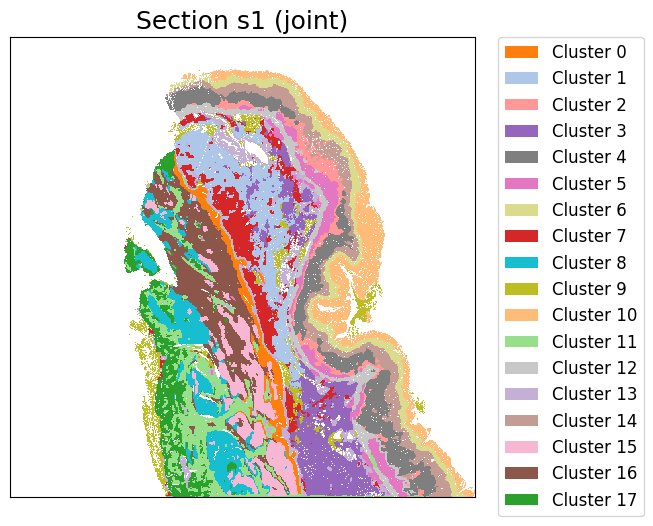

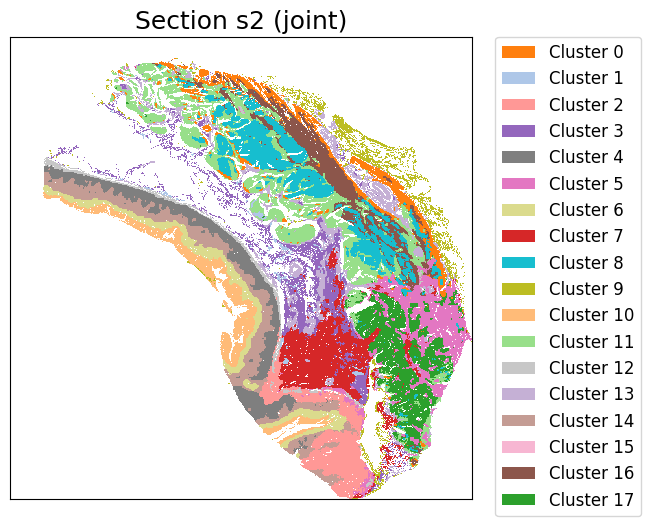

In [14]:
color_list = [[255,127,14],[174,199,232],[255,152,150],[148,103,189],
              [127,127,127],[227,119,194],[219,219,141],[214,39,40],
              [23,190,207],[188,189,34],[255,187,120],[152,223,138],
              [199,199,199],[197,176,213],[196,156,148],[247,182,210],
              [140,86,75],[44,160,44],[158,218,229],[16,60,90],
              [128,64,7],[22,80,22],[107,20,20],[74,52,94],[70,43,38],
              [114,60,97],[64,64,64],[94,94,17],[12,95,104],[0,0,0]]


cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=18,   
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 colormap = color_list, 
                                                 dpi = 500,
                                                 figscale = 220)

## Predict protein for Section1

In [17]:
adata1_protein_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
[Protein] exists in ['s2'], which will be used as source data section


In [18]:
adata1_protein_predicted

AnnData object with n_obs × n_vars = 825621 × 19
    obsm: 'spatial'

In [19]:
adata1_protein_predicted_norm = adata1_protein_predicted.copy()
adata2_adt_norm = adata2_adt.copy()

In [20]:
adata1_protein_predicted_norm.X = np.arcsinh(adata1_protein_predicted_norm.X / 5)   # For COMET data
adata2_adt_norm.X = np.arcsinh(adata2_adt_norm.X / 5)   # For COMET data

In [21]:
adata1_protein_predicted_norm = create_normalized_adata(adata1_protein_predicted_norm)
adata2_adt_norm = create_normalized_adata(adata2_adt_norm)

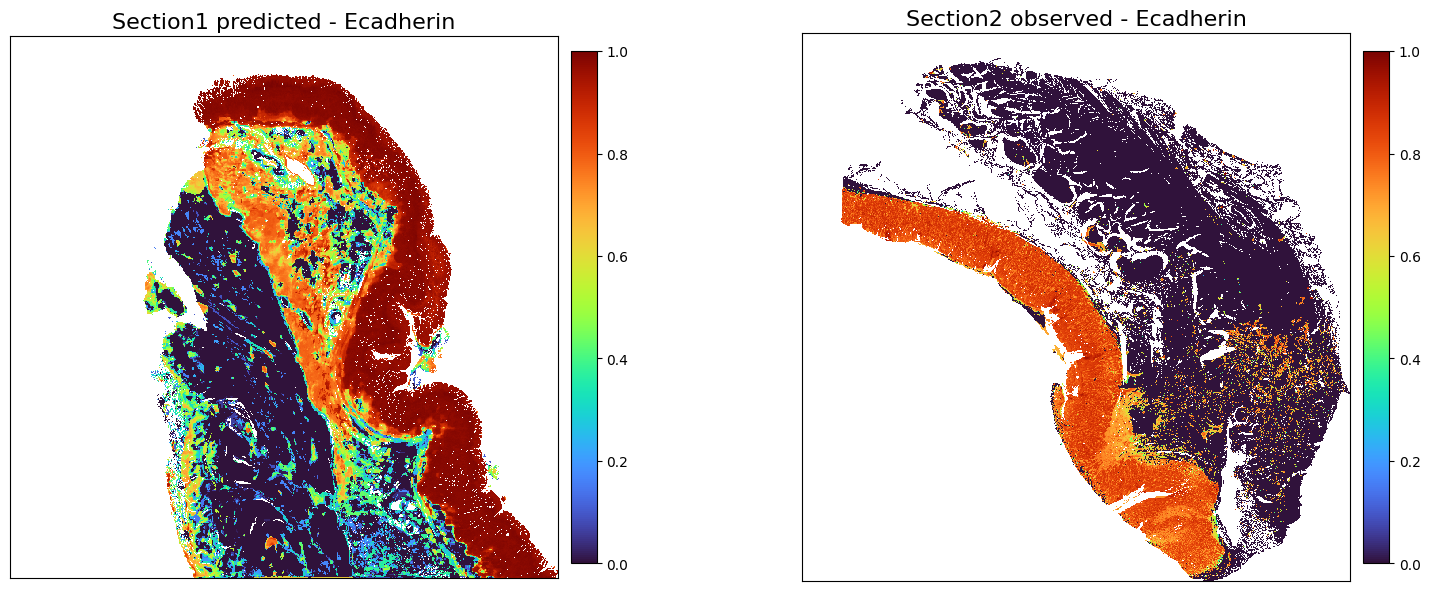

In [22]:
chosed_protein = 'Ecadherin'
plot_marker_comparison_superpixel(chosed_protein, 
                       adata1_protein_predicted_norm, 
                       adata2_adt_norm, 
                       'Section1 predicted', 
                       'Section2 observed',
                        figscale = 150,)

## Predict RNA for Section2

In [35]:
adata2_rna_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s2] as spatial/obs reference
[RNA] exists in ['s1'], which will be used as source data section


In [36]:
adata2_rna_predicted_norm = create_normalized_adata(adata2_rna_predicted)
adata1_rna_norm = create_normalized_adata(adata1_rna)

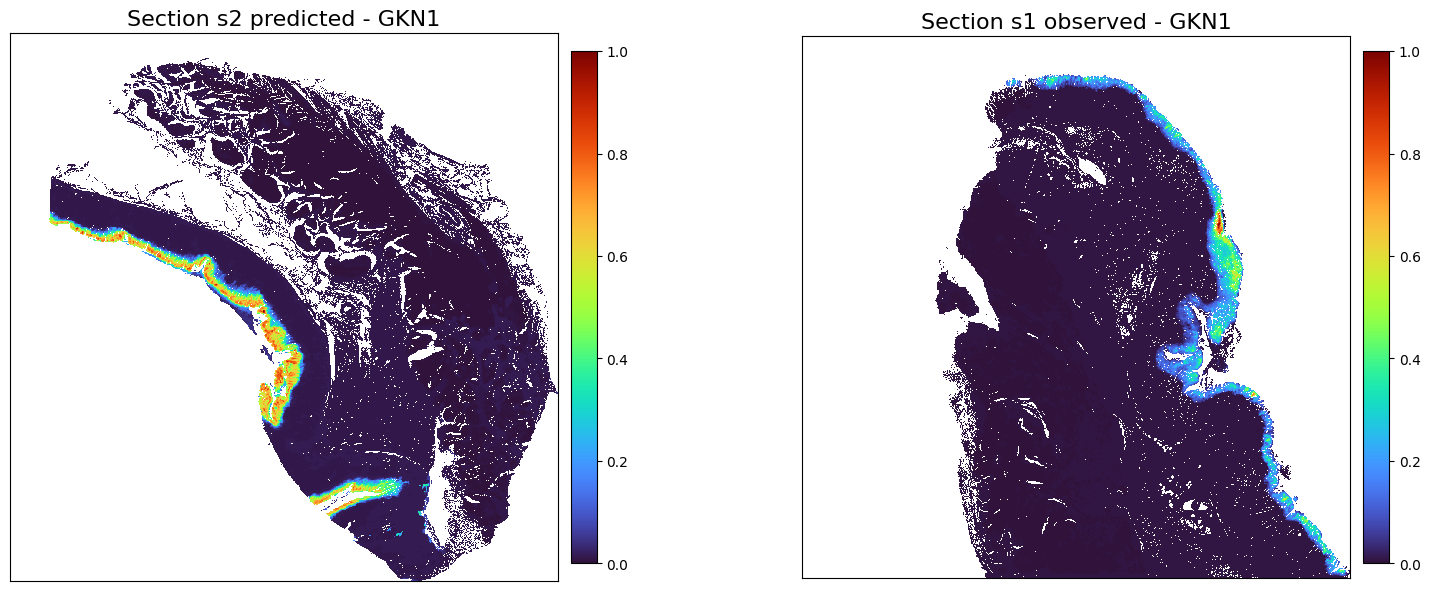

In [37]:
chosed_gene = 'GKN1'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata1_rna_norm, 
                       'Section s2 predicted', 
                       'Section s1 observed',
                        figscale = 150)

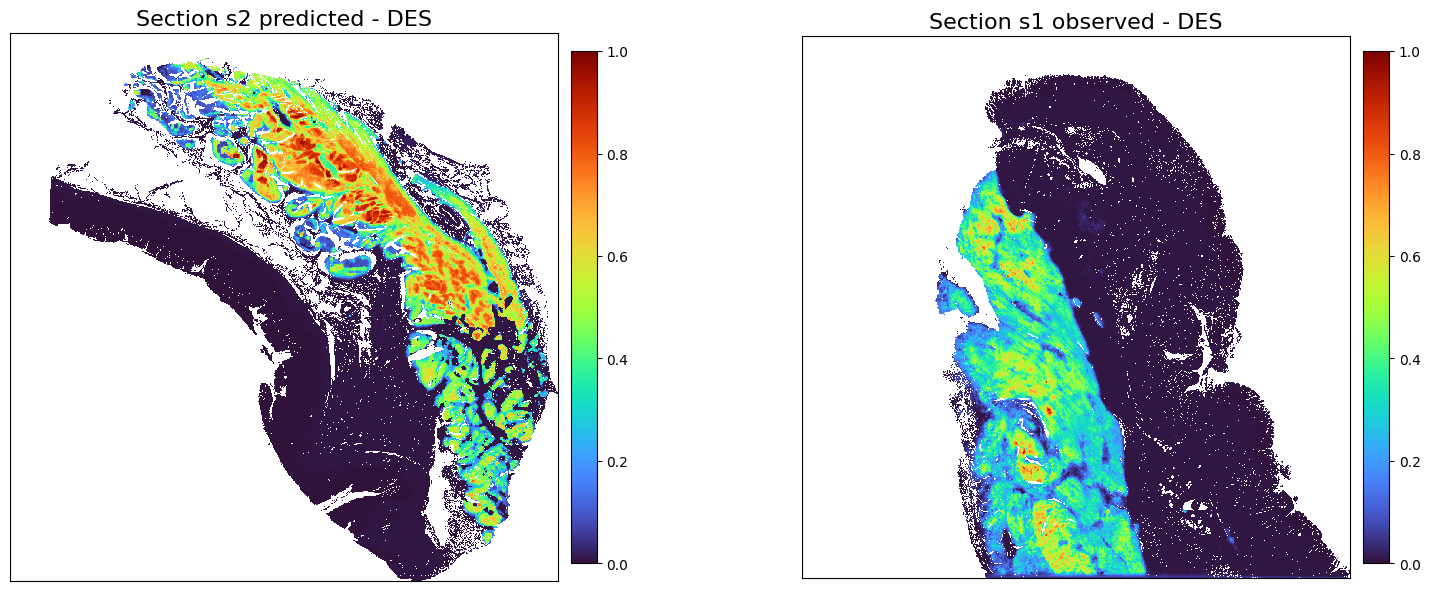

In [38]:
chosed_gene = 'DES'
plot_marker_comparison_superpixel(chosed_gene, 
                       adata2_rna_predicted_norm, 
                       adata1_rna_norm, 
                       'Section s2 predicted', 
                       'Section s1 observed',
                        figscale = 150)